In [1]:
rootF = 'D:/Data/Paper defocus/Defocus detection data/'

In [2]:
import os as os
import sys
import csv
import math
import numpy as np
from scipy.stats import *

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.gridspec import SubplotSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from shared.save_load import *
from shared.functions import convert_pvalue_to_stars

In [3]:
experiments = [20211129, 20211207, 20211208, 20221213, 20221214, 20230105]

# Experiment conditions
from shared.parameters_stimulation2 import *
pixel_size_um = 3.5
pixel_per_check = 12
nb_checks = 60

# Load data

## Cleaned Baden types

In [4]:
Folder = rootF + '/MEA/RGC typing/calcium comparison/'

euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     

In [5]:
euler_label_names = []

for i in range(len(euler_labels)):
    euler_label_names.append(euler_labels[i][0])

## Spike counts

In [6]:
spike_counts_data = np.load(rootF + '/MEA/Spike_counts_merged_experiments.npz',\
                    allow_pickle=True)

clusters = spike_counts_data['clusters']
spike_counts_mean = spike_counts_data['spike_counts_mean']
spike_counts_std = spike_counts_data['spike_counts_std']
delta_spike_counts = spike_counts_data['delta_spike_counts']

## Firing rates

In [7]:
exp = 20211129
firing_rates_data = np.load(rootF + '/MEA/exp' + str(exp) + '/' + str(exp) + '_cells_firing_rates.npz',\
                    allow_pickle=True)
    
firing_rates = firing_rates_data['firing_rates'] 
good_cells = firing_rates_data['clusters']

## Original images

In [8]:
path_to_original_images = rootF + '/Eye model simulations/original images/'
    
images = ['1','2','3','5']

# Select cell types

In [9]:
for iLabel in range(len(euler_labels)):
    cell_type = euler_labels[iLabel][0]
    
    if len(delta_spike_counts[iLabel]) > 0:
        # Distribution off delta spike count
        max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,:]))
        lim = 1.2 * max_delta_sp_cnt

        p_values = []

        for iEcc in [0,2]:
            ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                                    /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
            ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                                    /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())

            p_neg = ratio_neg_deltas/100
            p_pos = ratio_pos_deltas/100
            n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
            error_neg_ratios = (p_neg * (1-p_neg)/n_stats) * 100
            error_pos_ratios = (p_pos * (1-p_pos)/n_stats) * 100
            
            ### Wilcoxon test
            delta_SC = delta_spike_counts[iLabel][:,:,iEcc].flatten()
            samples_neg = delta_SC[delta_SC < 0]
            samples_pos = delta_SC[delta_SC > 0]
            test = wilcoxon(delta_SC[delta_SC != 0])
            test_neg = wilcoxon(delta_SC[delta_SC != 0], alternative='less')
#             print (cell_type, test)
            p_values.append(test[1])

        if p_values[0] < 0.05 and p_values[1] < 0.05:
            print ('p < 0.05 :', iLabel, cell_type, p_values[0])
        # if p_values[0] < 0.02 and p_values[1] < 0.02:
        #     print ('p < 0.02 :', cell_type)


p < 0.05 : 3 OFF slow 9.18380101211369e-05
p < 0.05 : 4 OFF alpha sustained 0.010629078706548986
p < 0.05 : 5 ON-OFF JAM-B 0.011082439230721115
p < 0.05 : 6 OFF sustained 0.0023907003924250603
p < 0.05 : 13 ON-OFF local OS 0.009608790278434753


# Figures

In [10]:
cols = ['C0','C1','C2','C3']
defocuses = np.linspace(40, -40, 9)
mouse_dF_to_um_ratio = -5 #um
mouse_offset = defocuses * mouse_dF_to_um_ratio

iPup = 0
iPol = 0

print (mouse_offset)

[-200. -150. -100.  -50.   -0.   50.  100.  150.  200.]


In [11]:
def get_euler():
    vec_path = rootF + '/MEA/'
        
    vec_path = vec_path + r"euler.vec"
    euler_vec = np.genfromtxt(vec_path)

    return euler_vec

euler_vec= get_euler()

# Reviews

OFF type 4 9  cells
Ecc 0
77.77777777777777 19.444444444444443
p-value 4.591900506056845e-05
Ecc 2
63.888888888888886 27.77777777777778
p-value 0.012665497837588191
ON-OFF type 14 7  cells
Ecc 0
71.42857142857143 25.0
p-value 0.012665497837588191
Ecc 2
60.714285714285715 21.428571428571427
p-value 0.012665497837588191
ON alpha 55  cells
Ecc 0
50.0 47.27272727272727
p-value 0.14855138331969142
Ecc 2
44.09090909090909 52.27272727272727
p-value 0.8653985511474649


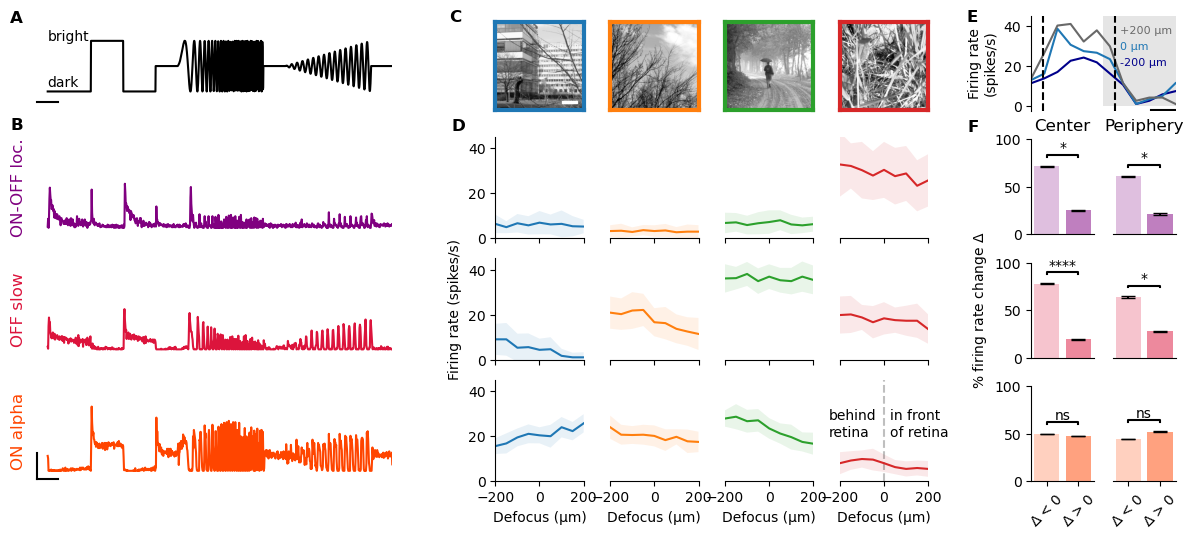

In [28]:
fig = plt.figure(figsize=(12, 5.5))
GS = fig.add_gridspec(1,3, width_ratios = [2.5, 3, 1])

######################### CHIRPS #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=GS[0], wspace = 0.3)

### Stim
ax = fig.add_subplot(gs[0])
ax.plot(np.linspace(0,32,1600), euler_vec[150:1750,1]/np.amax(euler_vec[150:1750,1]), color='k')
ax.plot([-1,1],[-0.2,-0.2], 'k-')
ax.set_ylim(-0.5,1.5)
ax.set_xlim(-1.5,32)
ax.axis('off')
ax.text(-3.5, 1.37, 'A', color='k', fontsize = 12, weight='bold')
ax.text(0, 0.1, 'dark', color='k') #, fontsize = 12,)
ax.text(0, 1, 'bright', color='k') #, fontsize = 12,)

### ON-OFF local OS
exp = 20211208
cell_nb = 130
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[1])
ax.set_ylabel('ON-OFF loc.', color='purple', fontsize=12)
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'purple')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)
ax.text(-3.5, 190, 'B', color='k', fontsize = 12, weight='bold')

### OFF slow
exp = 20211208
cell_nb = 20
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[2])
ax.set_ylabel('OFF slow', color = 'crimson', fontsize=12)
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'crimson')
# ax.plot([-1,-1],[0,50], 'k-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)

### ON alpha
exp = 20211208
cell_nb = 449
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[3])
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'orangered')
ax.plot([-1,-1],[-15,35], 'k-')
ax.plot([-1,1],[-15,-15], 'k-')
ax.set_ylabel('ON alpha', color='orangered', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)

######################### EXAMPLE DATA #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=GS[1], wspace = 0.3)

### ON-OFF local
iLabel = 13
cell = 130 #460 #558 
idx_cell = 4 #6 #0 

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[1, iImg])
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc] * 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, label = 'mean $\pm$ STD', linewidth = 0)
    ax.set_ylim(0, 45) #sc_max)
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    if iImg == 0:
        ax.text(-400, 48, 'D', color='k', fontsize = 12, weight='bold')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

### OFF slow
iLabel = 3
cell = 20
idx_cell = 6 #where(array(clusters[iLabel][iExp]) == cell)[0][0]

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[2, iImg])
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, label = 'mean $\pm$ STD', linewidth = 0)
    ax.set_ylim(0, 45) 
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    if iImg == 0:
        ax.set_ylabel('Firing rate (spikes/s)')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

### ON alpha
iLabel = 23
cell = 449
idx_cell = 27 #where(array(clusters[iLabel][iExp]) == cell)[0][0]

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[3,iImg])
    if iImg == 3:
        ax.axvline(0, color = 'k', alpha = 0.25, ls = '--')
        ax.text(25,20, 'in front\nof retina')
        ax.text(-250,20, 'behind\nretina')
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, linewidth = 0)
    ax.set_ylim(0, 45)
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if iImg != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    ax.set_xlabel('Defocus (µm)')
        
### Original images
for iImg in range(Nimgs):
    img = plt.imread(path_to_original_images + 'image_' + images[iImg] + '_image.png')

    ax = fig.add_subplot(gs[0,iImg])
    ax.imshow(img, cmap='Greys_r')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['bottom'].set_color(cols[iImg])
    ax.spines['top'].set_color(cols[iImg])
    ax.spines['left'].set_color(cols[iImg])
    ax.spines['right'].set_color(cols[iImg])
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    if iImg == 0:
        ax.text(-450, 0, 'C', color='k', fontsize = 12, weight='bold')
    if iImg == 0:
        scalebar = AnchoredSizeBar(ax.transData, 143, '', 'lower right', pad=0.5, color='white',frameon=False, sep=-10, \
                           size_vertical=20, borderpad = 0)
        ax.add_artist(scalebar)
        
######################################### RAW DATA EXAMPLE #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 2, subplot_spec=GS[2], wspace = 0.3, hspace = 0.3)

raster_len = 0.6
bin_size = 0.05
iImg = 0
iEcc = 2
iPup = 0
iCell = np.where(good_cells == 404)[0][0] #3

colors = ['darkblue', 'C0', 'dimgray']

ax = fig.add_subplot(gs[0,:])

for iDf in [0,4,8]:
    ax.plot(np.linspace(0,0.6,12), firing_rates[iCell,iImg,iPup,iDf,iEcc], color=colors[int(iDf/4)], label=mouse_offset[iDf])
ax.axvline(0.05, ymin = 0, c='k', ls='--')
ax.axvline(0.35, ymin = 0, c='k', ls='--')
ax.fill_between([0.3, 0.6], 0, 45, facecolor='k', alpha=0.1, linewidth=0.0)
ax.plot([0.5,0.6],[-2,-2], 'k-')
ax.set_ylim(-2.5, 45)
ax.set_xlim(0, raster_len)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_ylabel('Firing rate\n(spikes/s)')
ax.text(-0.27, 42, 'E', color='k', fontsize = 12, weight='bold')

ax.text(0.37, 36, '+200 µm', color=colors[2], fontsize = 8)
ax.text(0.37, 28, '0 µm', color=colors[1], fontsize = 8)
ax.text(0.37, 20, '-200 µm', color=colors[0], fontsize = 8)

######################################### POP ANALSYIS #########################################

### OFF slow
iLabel = 3
iExp = 2

# Distribution off delta spike count
max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,:]))
lim = 1.2 * max_delta_sp_cnt

print ('OFF type 4', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100

    # Wilcoxon test
    delta_SC = delta_spike_counts[iLabel][:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[2, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='crimson')
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='crimson')
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    if iEcc != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    if iEcc == 0:
        ax.set_ylabel('% firing rate change $\Delta$')
        
### ON OFF local OS

iLabel = 13
iExp = 0

max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,0]))
lim = 1.2 * max_delta_sp_cnt

print ('ON-OFF type 14', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100

    # Wilcoxon testS[:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[1, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='purple',
          label = 'p = %0.3f'%test[1])
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='purple')
    if iEcc == 0:
        ax.set_title('Center', y=1)
        ax.text(-1.5, 108, 'F', color='k', fontsize = 12, weight='bold')
    elif iEcc == 2:
        ax.set_title('Periphery', y=1)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    
### ON alpha
iLabel = 23
iExp = 2
            
# Distribution off delta spike count
max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,:]))
lim = 1.2 * max_delta_sp_cnt

print ('ON alpha', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats) * 100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats) * 100
    
    # Wilcoxon test
    delta_SC = delta_spike_counts[iLabel][:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[3, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='orangered')
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_pos_ratios, ecolor='black', capsize=5, alpha=0.5, color='orangered')
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['$\Delta$ < 0', '$\Delta$ > 0'], rotation=45)
    if iEcc != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

plt.tight_layout()

### Save figure
fig_path = 'T:/Documents/Papier defocus/figures/papier/'
fsave = fig_path + 'Fig2_raw'
# fig.savefig(fsave+'.pdf', format='pdf', dpi=300)
fig.savefig(fsave+'.png', format='png', dpi=300)

OFF type 4 9  cells
Ecc 0
77.77777777777777 19.444444444444443
p-value 4.591900506056845e-05
Ecc 2
63.888888888888886 27.77777777777778
p-value 0.012665497837588191
ON-OFF type 14 7  cells
Ecc 0
71.42857142857143 25.0
p-value 0.012665497837588191
Ecc 2
60.714285714285715 21.428571428571427
p-value 0.012665497837588191
ON alpha 55  cells
Ecc 0
50.0 47.27272727272727
p-value 0.14855138331969142
Ecc 2
44.09090909090909 52.27272727272727
p-value 0.8653985511474649


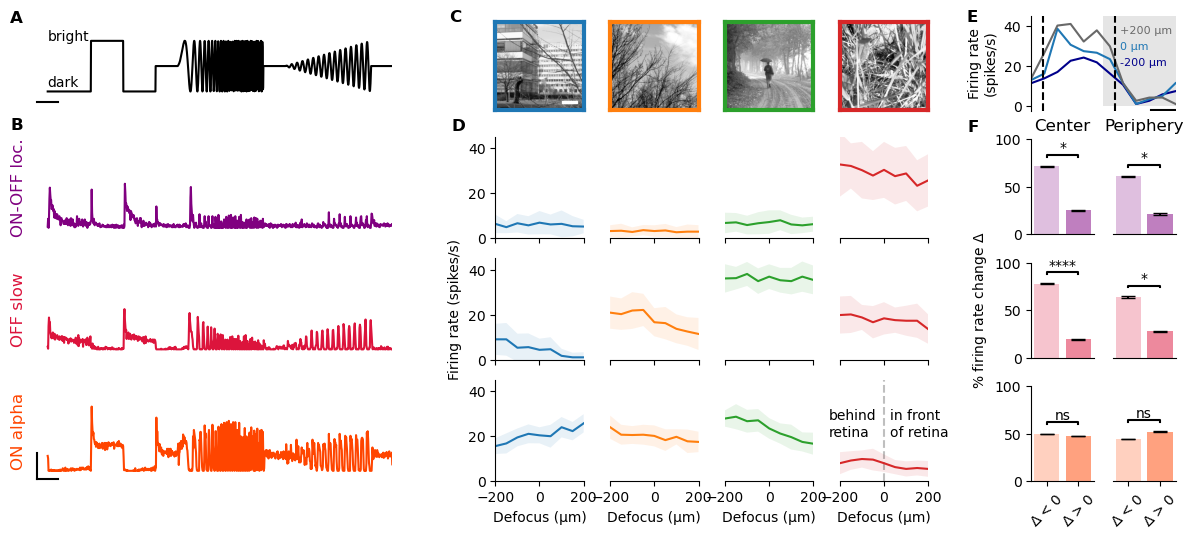

In [ ]:
fig = plt.figure(figsize=(12, 5.5))
GS = fig.add_gridspec(1,3, width_ratios = [2.5, 3, 1])

######################### CHIRPS #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=GS[0], wspace = 0.3)

### Stim
ax = fig.add_subplot(gs[0])
ax.plot(np.linspace(0,32,1600), euler_vec[150:1750,1]/np.amax(euler_vec[150:1750,1]), color='k')
ax.plot([-1,1],[-0.2,-0.2], 'k-')
ax.set_ylim(-0.5,1.5)
ax.set_xlim(-1.5,32)
ax.axis('off')
ax.text(-3.5, 1.37, 'A', color='k', fontsize = 12, weight='bold')
ax.text(0, 0.1, 'dark', color='k') #, fontsize = 12,)
ax.text(0, 1, 'bright', color='k') #, fontsize = 12,)

### OFF slow
exp = 20211208
cell_nb = 20
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[1])
ax.set_ylabel('OFF slow', color = 'purple', fontsize=12)
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'purple')
# ax.plot([-1,-1],[0,50], 'k-')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)
ax.text(-3.5, 175, 'B', color='k', fontsize = 12, weight='bold')

### ON-OFF local OS
exp = 20211208
cell_nb = 130
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[2])
ax.set_ylabel('ON-OFF local', color='crimson', fontsize=12)
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'crimson')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)

# Chirp
exp = 20211208
cell_nb = 449
data_path = rootF + '/MEA/exp' + str(exp) + '/'
cell_data = load_obj(data_path + 'cells_characterization_data_' + str(exp))

ax = fig.add_subplot(gs[3])
ax.plot(np.linspace(0,32,800), cell_data[cell_nb]['psth'], 'orangered')
ax.plot([-1,-1],[-15,35], 'k-')
ax.plot([-1,1],[-15,-15], 'k-')
ax.set_ylabel('ON alpha', color='orangered', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(-20,175)
ax.set_xlim(-1.5,32)

######################### EXAMPLE DATA #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=GS[1], wspace = 0.3)

### OFF slow
iLabel = 3
cell = 20
idx_cell = 6 #where(array(clusters[iLabel][iExp]) == cell)[0][0]

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[1, iImg])
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, label = 'mean $\pm$ STD', linewidth = 0)
    ax.set_ylim(0, 45) 
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    if iImg == 0:
        ax.text(-400, 45, 'D', color='k', fontsize = 12, weight='bold')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

### ON-OFF local
iLabel = 13
cell = 130 #460 #558 
idx_cell = 4 #6 #0 

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[2, iImg])
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc] * 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, label = 'mean $\pm$ STD', linewidth = 0)
    ax.set_ylim(0, 45) #sc_max)
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([])
    if iImg == 0:
        ax.set_ylabel('Firing rate (spikes/s)')
    else:
        ax.spines['left'].set_visible(False)
#         ax.set_yticklabels([])
        ax.set_yticks([])
        
### ON alpha
iLabel = 23
cell = 449
idx_cell = 27 #where(array(clusters[iLabel][iExp]) == cell)[0][0]

iEcc = 2
sc_max = 1.2*np.amax(spike_counts_mean[iLabel][idx_cell])
for iImg in range(Nimgs):
    ax = fig.add_subplot(gs[3,iImg])
    if iImg == 3:
        ax.axvline(0, color = 'k', alpha = 0.25, ls = '--')
        ax.text(25,20, 'in front\nof retina')
        ax.text(-250,20, 'behind\nretina')
    # if iImg == 0:
    #     ax.text(25,20, 'in front\nof retina')
    ax.plot(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3, color = cols[iImg])
    ax.fill_between(mouse_offset, spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 - \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3, \
                    spike_counts_mean[iLabel][idx_cell, iImg, iEcc]* 1/0.3 + \
                    spike_counts_std[iLabel][idx_cell, iImg, iEcc]* 1/0.3,
                    facecolor = cols[iImg], alpha = 0.1, linewidth = 0)
    # if iImg == 0:
    #     plt.arrow(x=196, y=spike_counts_mean[iLabel][idx_cell, iImg, iEcc, 0] * 1/0.3, \
    #               dx=0, dy=(spike_counts_mean[iLabel][idx_cell, iImg, iEcc, 8] - spike_counts_mean[iLabel][idx_cell, iImg, iEcc, 0]),\
    #               head_width = 1, head_length = 1) #color = "C0", alpha = 0.25, linestyle = '--', width=2)
    ax.set_ylim(0, 45)
    ax.set_xlim(-200, 200)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if iImg != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    ax.set_xlabel('Defocus (µm)')
        
### Original images
for iImg in range(Nimgs):
    img = plt.imread(path_to_original_images + 'image_' + images[iImg] + '_image.png')

    ax = fig.add_subplot(gs[0,iImg])
    ax.imshow(img, cmap='Greys_r')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['bottom'].set_color(cols[iImg])
    ax.spines['top'].set_color(cols[iImg])
    ax.spines['left'].set_color(cols[iImg])
    ax.spines['right'].set_color(cols[iImg])
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    if iImg == 0:
        ax.text(-450, 0, 'C', color='k', fontsize = 12, weight='bold')
    if iImg == 0:
        scalebar = AnchoredSizeBar(ax.transData, 143, '', 'lower right', pad=0.5, color='white',frameon=False, sep=-10, \
                           size_vertical=20, borderpad = 0)
        ax.add_artist(scalebar)
        
######################################### RAW DATA EXAMPLE #########################################

gs = gridspec.GridSpecFromSubplotSpec(4, 2, subplot_spec=GS[2], wspace = 0.3, hspace = 0.3)

raster_len = 0.6
bin_size = 0.05
iImg = 0
iEcc = 2
iPup = 0
iCell = np.where(good_cells == 404)[0][0] #3

colors = ['darkblue', 'C0', 'dimgray']

ax = fig.add_subplot(gs[0,:])

for iDf in [0,4,8]:
    ax.plot(np.linspace(0,0.6,12), firing_rates[iCell,iImg,iPup,iDf,iEcc], color=colors[int(iDf/4)], label=mouse_offset[iDf])
ax.axvline(0.05, ymin = 0, c='k', ls='--')
ax.axvline(0.35, ymin = 0, c='k', ls='--')
ax.fill_between([0.3, 0.6], 0, 45, facecolor='k', alpha=0.1, linewidth=0.0)
ax.plot([0.5,0.6],[-2,-2], 'k-')
ax.set_ylim(-2.5, 45)
ax.set_xlim(0, raster_len)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_ylabel('Firing rate\n(spikes/s)')
ax.text(-0.27, 42, 'E', color='k', fontsize = 12, weight='bold')

ax.text(0.37, 36, '+200 µm', color=colors[2], fontsize = 8)
ax.text(0.37, 28, '0 µm', color=colors[1], fontsize = 8)
ax.text(0.37, 20, '-200 µm', color=colors[0], fontsize = 8)

######################################### POP ANALSYIS #########################################

### OFF slow
iLabel = 3
iExp = 2

# Distribution off delta spike count
max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,:]))
lim = 1.2 * max_delta_sp_cnt

print ('OFF type 4', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100

    # Wilcoxon test
    delta_SC = delta_spike_counts[iLabel][:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[1, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='purple')
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='purple')
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    if iEcc != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    if iEcc == 0:
        ax.set_title('Center', y=1)
        ax.text(-1.5, 100, 'F', color='k', fontsize = 12, weight='bold')
    elif iEcc == 2:
        ax.set_title('Periphery', y=1)
        
### ON OFF local OS

iLabel = 13
iExp = 0

max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,0]))
lim = 1.2 * max_delta_sp_cnt

print ('ON-OFF type 14', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100

    # Wilcoxon testS[:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[2, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='crimson',
          label = 'p = %0.3f'%test[1])
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='crimson')
    if iEcc == 0:
        ax.set_ylabel('% firing rate change $\Delta$')
    else:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    
### ON alpha
iLabel = 23
iExp = 2
            
# Distribution off delta spike count
max_delta_sp_cnt = np.nanmax(abs(delta_spike_counts[iLabel][:,:,:]))
lim = 1.2 * max_delta_sp_cnt

print ('ON alpha', len(delta_spike_counts[iLabel][:,0,iEcc]), ' cells')

for iEcc in [0,2]:
    print ('Ecc', iEcc)
    ratio_neg_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() < 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    ratio_pos_deltas = 100*len(np.where(delta_spike_counts[iLabel][:,:,iEcc].flatten() > 0)[0])\
                            /len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    print (ratio_neg_deltas, ratio_pos_deltas)
    p_neg = ratio_neg_deltas/100
    p_pos = ratio_pos_deltas/100
    n_stats = len(delta_spike_counts[iLabel][:,:,iEcc].flatten())
    error_neg_ratios = (p_neg * (1-p_neg)/n_stats) * 100
    error_pos_ratios = (p_pos * (1-p_pos)/n_stats) * 100
    
    # Wilcoxon test
    delta_SC = delta_spike_counts[iLabel][:,:,iEcc].flatten()
    samples_neg = delta_SC[delta_SC < 0]
    samples_pos = delta_SC[delta_SC > 0]
    test = wilcoxon(delta_SC[delta_SC != 0], alternative = 'less')
    print ('p-value', test[1])

    # Barplots
    ax = fig.add_subplot(gs[3, int(iEcc/2)])
    # p-values
    x1, x2 = 1, 2
    y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
    # plot
    ax.bar(x = 1, height = ratio_neg_deltas, yerr=error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='orangered')
    ax.bar(x = 2, height = ratio_pos_deltas, yerr=error_pos_ratios, ecolor='black', capsize=5, alpha=0.5, color='orangered')
    ax.set_ylim(0, 100)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['$\Delta$ < 0', '$\Delta$ > 0'], rotation=45)
    if iEcc != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])

plt.tight_layout()

### Save figure
fig_path = 'T:/Documents/Papier defocus/figures/papier/'
fsave = fig_path + 'Fig2_v2'

# fig.savefig(fsave+'.pdf', format='pdf', dpi=300)
# fig.savefig(fsave+'.png', format='png', dpi=300)